# Quantum Lab2: Phase estimation

## Part 1: Performance of Quantum Phase Estimation

Goal of this lab:

Investigate the relationship between the number of qubits required for the desired accuracy of the phase estimation with high probability.

The accuracy of the estimated value through Quantum Phase Estimation (QPE) and its probability of success depend on the number of qubits employed in QPE circuits. Therefore, one might want to know the necessary number of qubits to achieve the targeted level of QPE performance, especially when the phase that needs to be determined cannot be decomposed in a finite bit binary expansion. In Part 1 of this lab, we examine the number of qubits required to accomplish the desired accuracy and the probability of success in determining the phase through QPE.

In [1]:
from qiskit import *
from qiskit_aer import AerSimulator
import numpy as np
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import math
from qiskit.circuit.library import QFT
from termcolor import colored

In the following section, we want to do quantum phase estimation for gate $U_1(2\pi/3)$, with respect to eigen state $\ket{1}$

The following page give the definition of $U_1$ gate:
https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.U1Gate

### 1. Find the probability of obtaining the estimation for a phase value accurate to $2^{-2}$ successfully with four counting qubits.

You are already provided with the circuit of quantum fourier transform.
Note that in QPE, you should use inverse qft, you might modify your code based on the following qft function

In [2]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit
def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)


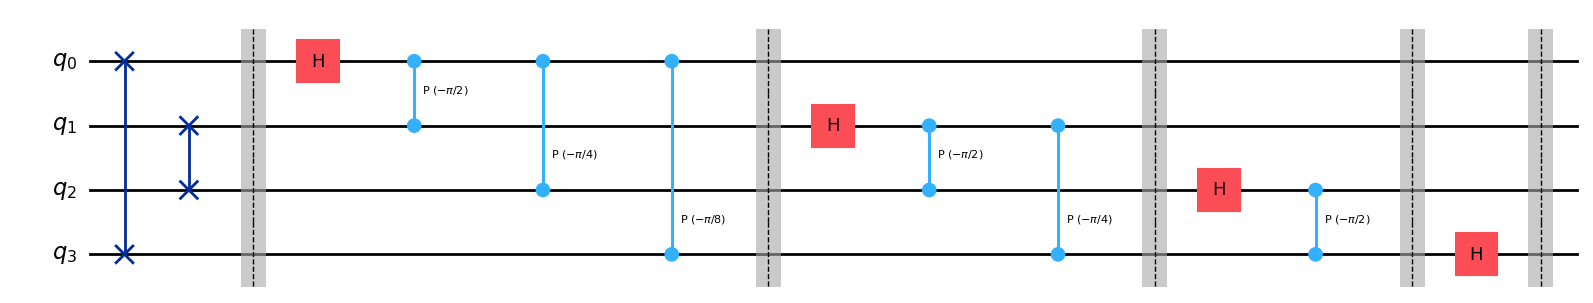

In [3]:
#Your code for inverse QFT here
def inverse_qft(qc, n):
    swap_registers(qc, n)
    qc.barrier()
    inverse_qft_rotations(qc, n)
    return qc

def inverse_qft_rotations(qc, n):
    if n ==0:
        return qc
    for i in range(n):
        qc.h(i)
        temp = i+1
        while temp < n:
            qc.cp(-np.pi/2**(temp-i), temp, i)
            temp = temp+1
        qc.barrier()
    return qc
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

qc = QuantumCircuit(4)
inverse_qft(qc, 4).draw(output = 'mpl')

#### 1.Step A. Set up the QPE circuit with four counting qubits and save the circuit to the variable 'qc4'. Execute 'qc4' on a qasm simulator. Plot the histogram of the result.

You can copy the following implemenetation to the test script and run the test by yourselves!
https://github.com/yezhuoyang/QuantumLab/blob/main/test/testPhaseEstimation.py

In [4]:
## Start your code to create the circuit, qc4
## Keep in mind that the target unitary is U_1(2\pi/3), and the eigen state is |1>


def qc4():
    ## Start your code to create the circuit
    n=5 #How man qubit you want to use?
    m=4 #How many classical bit your want to use?
    circuit=QuantumCircuit(n, m)    

    ##Your circuit construction goes here:
    
    #initializing bits
    #circuit.reset(range(n))
    for qubit in range(n-1):
        circuit.h(qubit)
    circuit.x(n-1) #initialize to eigenstate |1>
    circuit.barrier()
    #U gate applications
    reps = 1
    for qb in range(n-1):
        for i in range(reps):
            circuit.cp((2*np.pi)/3, qb, n-1)
        reps = reps*2
    circuit.barrier()
    #Inverse QFT
    circuit = inverse_qft(circuit, n-1)
    #measurement
    for qubit2 in range(n-1):
        circuit.measure(qubit2,qubit2)
    
    ##Your circuit construction ends here


    # We'll run the program on a simulator
    backend = AerSimulator()

    # Transpile the ideal circuit to a circuit that can be directly executed by the backend
    transpiled_circuit = transpile(circuit, backend)

    # Since the output will be deterministic, we can use just a single shot to get it
    job = backend.run(transpiled_circuit, shots=1000, memory=True)
    output = job.result().get_counts()

    return circuit, output

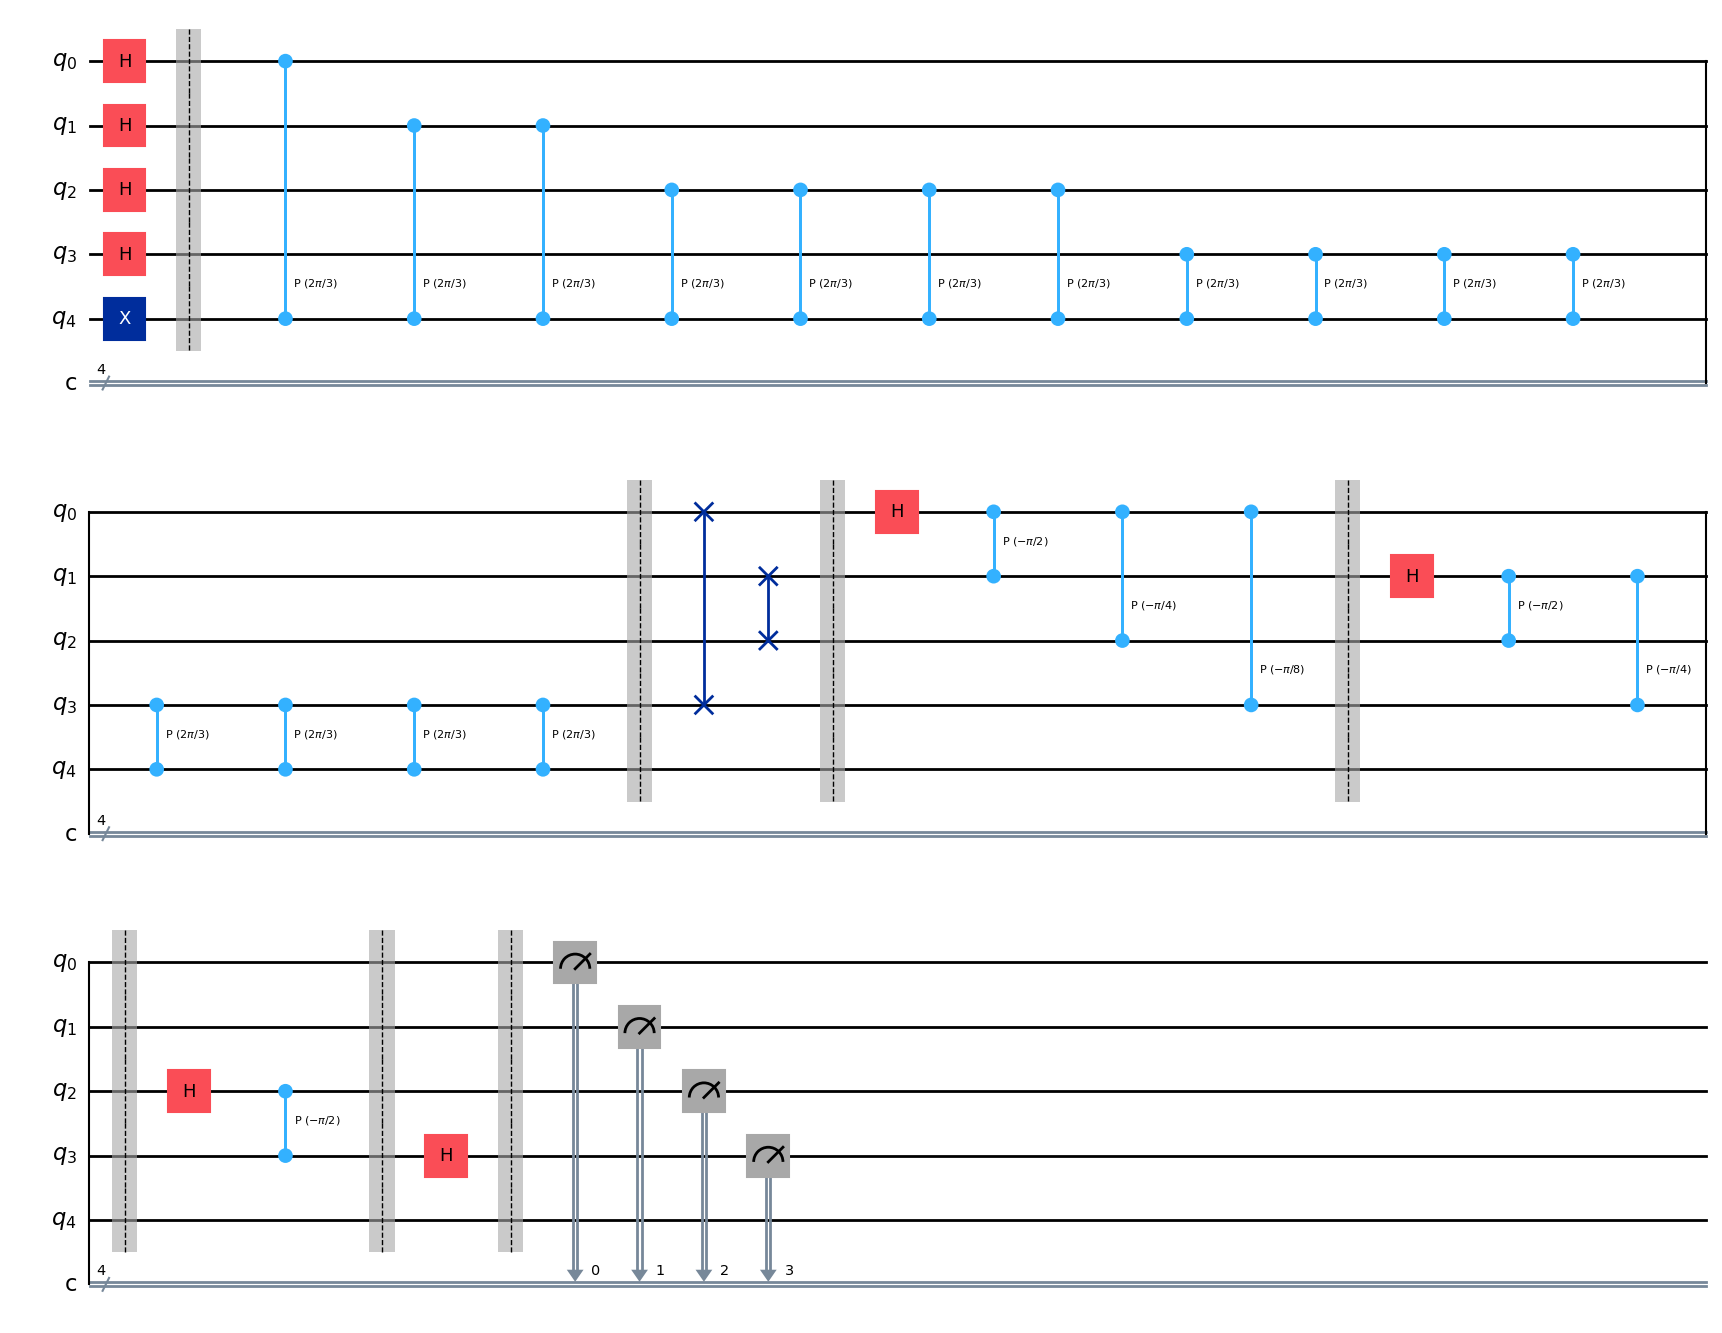

In [5]:
qc4_circuit,count_qc4=qc4()
qc4_circuit.draw(output = 'mpl')
#print(count_qc4)

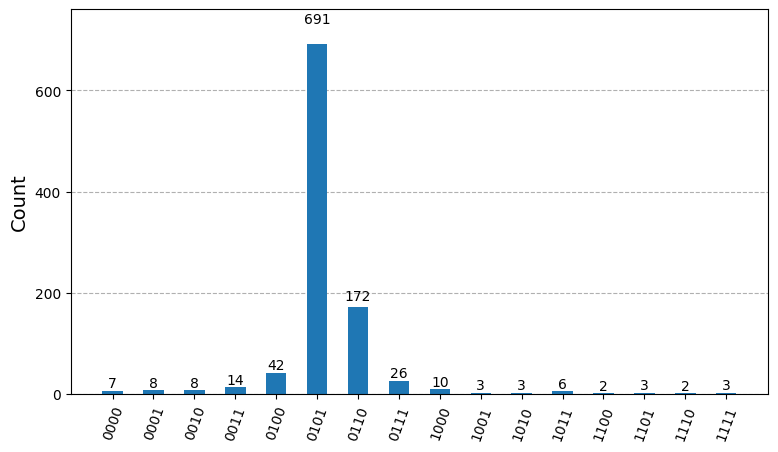

In [6]:
qc4_circuit,count_qc4=qc4()
plot_histogram(count_qc4, figsize=(9,5))

Having performed Step A successfully, you will have obtained a distribution similar to the one shown below with the highest probability at 0101 which corresponds to the estimated $\phi$ value, $0.3125$

![title](L5_qc4_hist.png)

Since the number of counting qubits used for the circuit is four, the best estimated value should be accurate to 
$\delta=2^{-4}=0.0625$. However, there are multiple possible outcomes as $\theta=1/3$ cannot be expressed in a finite number of bits, the estimation by QPE here is not always bounded by this accuracy.

Running the following cell shows the same histogram but with all possible estimated estimated $\phi$ values  on the x-axis

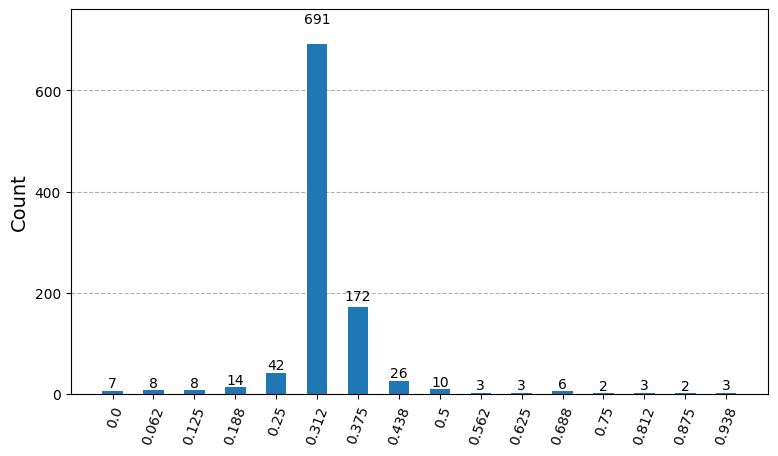

In [7]:
t=4
phi_est = np.array([round(int(k, 2)/2**t,3) for k in list(count_qc4.keys())])
key_new = list(map(str, phi_est))
count_new = dict(zip(key_new, count_qc4.values()))
plot_histogram(count_new, figsize=(9,5))

Suppose the outcome of the final measurement is , and let the best estimation which is $0.3125$ for this case.

#### Step B. Find e, the maximum difference in integer from the best estimation 0101 so that all the outcomes, 'm's, would approximate $\phi$ to an accuracy $2^{-2}$ when $|m-b|\leq \frac{e}{2^t}$

In this case, the value of $t$ and $b$ are $4$ and $0.3125$, respectively.

For example, under $e=1$, the considered outcomes are 0100, 0101, 0110 which correspond to the values of $m$: 
$0.25,0.312,0.375$, respectively, and all of them approximate the value $\frac{1}{3}$ to an accuracy $2^{-2}$.

In [8]:
# Your code goes here
t=4
b = .3125
phi_est = sorted(np.array([round(int(k, 2)/2**t,3) for k in list(count_qc4.keys())]))
range_acc = .25
updated = []
for m in phi_est: #loop over phi_est, if the term is > .25 off from b then we don't want it
    if np.abs(m-b) <= range_acc:
        updated.append(np.abs(m-b))
print(updated)
max_val = np.max(updated) #take the maximum difference in |m-b|, we find e from solving max<= e/2^t
e = int(max_val*(2**t)) #this will result in the minimal e such that all m's approximate phi =1/3 to an accuracy 
print("Here, e =", e)


[np.float64(0.1875), np.float64(0.1245), np.float64(0.0625), np.float64(0.0005000000000000004), np.float64(0.0625), np.float64(0.1255), np.float64(0.1875), np.float64(0.24950000000000006)]
Here, e = 3


#### Step C: Compute the probability of obtaining an approximation correct to an accuracy $2^{-2}$. Verify that the computed probability value is larger or equal to $1-\frac{1}{2(2^{(t-n)}-2)}$ where $t$ is the number of counting bits and the $2^{-n}$ is the desired accuracy.

Now it is easy to evaluate the probability of the success from the histogram since all the outcomes that approximate $\phi$ to the accuracy 
$2^{-2}$ can be found based on the maximum difference $e$ from the best estimate.

In [153]:
# Your code goes here

#we know e = 3 from my code above
e = 3
t = 4
b = .3125

corr_count = 0
total_count = 0
keys = sorted(list(count_new.keys()))
ind = keys.index('0.312')
for a in range(len(keys)):
    if np.abs(a - ind) <=e:
        corr_count = corr_count + int(count_new[keys[a]])
    total_count = total_count + int(count_new[keys[a]])
print("The probability of a successful approximation is:", corr_count/total_count)
val_thresh = 1-(1/(2*(2**(t-2) - 2)))
print("The value it must be larger than is:", val_thresh)

The probability of a successful approximation is: 0.965
The value it must be larger than is: 0.75


### 2. Compute the probability of success for the accuracy $2^{-2}$, when the number of counting qubits $t$, varies from four to nine. Compare your result with the equation $t=n+\log(2+\frac{1}{2\epsilon})$ when $2^{-n}$ is the desired accuracy and $\epsilon$ is 1-probability of success

The following plot shows the relationship between the number of counting qubit, $t$, and the minimum probability of success to approximate the phase to an accuracy $2^{-2}$. Check the Ch. 5.2.1 Performance and requirements in [Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information].

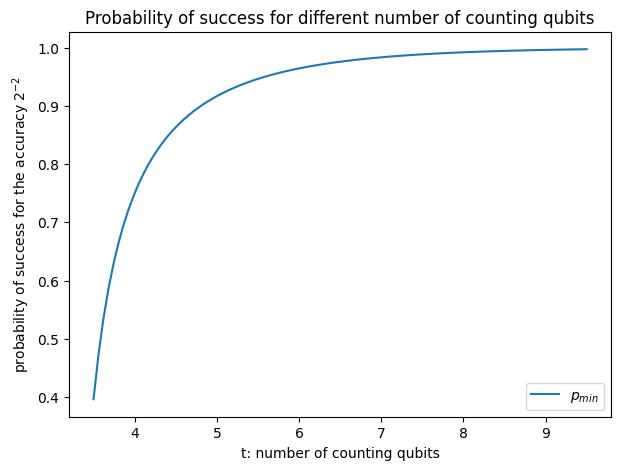

In [9]:
y = lambda t, n: 1-1/(2*(2**(t-n)-2))
t_q = np.linspace(3.5, 9.5, 100 )
p_min = y(t_q, 2)

plt.figure(figsize=(7, 5))
plt.plot(t_q, p_min, label='$p_{min}$')
plt.xlabel('t: number of counting qubits')
plt.ylabel('probability of success for the accuracy $2^{-2}$')
plt.legend(loc='lower right')
plt.title('Probability of success for different number of counting qubits')
plt.show()

#### Step A. Construct QPE circuit to estimate $\phi$ when $\phi=1/3$ with for the different number of counting qubits $t$ , when $t=[4,5,6,7,8,9]$. Store all the circuits in a list variable 'circ' to simulate all the circuits at once as we did in Lab3.

In [156]:
## Your Code to create the list variable 'circ' goes here

def qc_circ(t):
    n = t+1
    qc = QuantumCircuit(n, t)   
    ##Your circuit construction goes here:
    #initializing bits
    qc.reset(range(n-1))
    for qubit in range(n-1):
        qc.h(qubit)
    qc.x(n-1) #initialize to eigenstate |1>
    qc.barrier()
    #U gate applications
    reps = 1
    for qb in range(n-1):
        for i in range(reps):
            qc.cp((2*np.pi)/3, qb, n-1)
        reps = reps*2
    qc.barrier()
    #Inverse QFT
    qc = inverse_qft(qc, n-1)
    #measurement
    for qubit in range(n-1):
        qc.measure(qubit,qubit)
    return qc

circ = []
for i in range(4,10):
    circ.append(qc_circ(i))

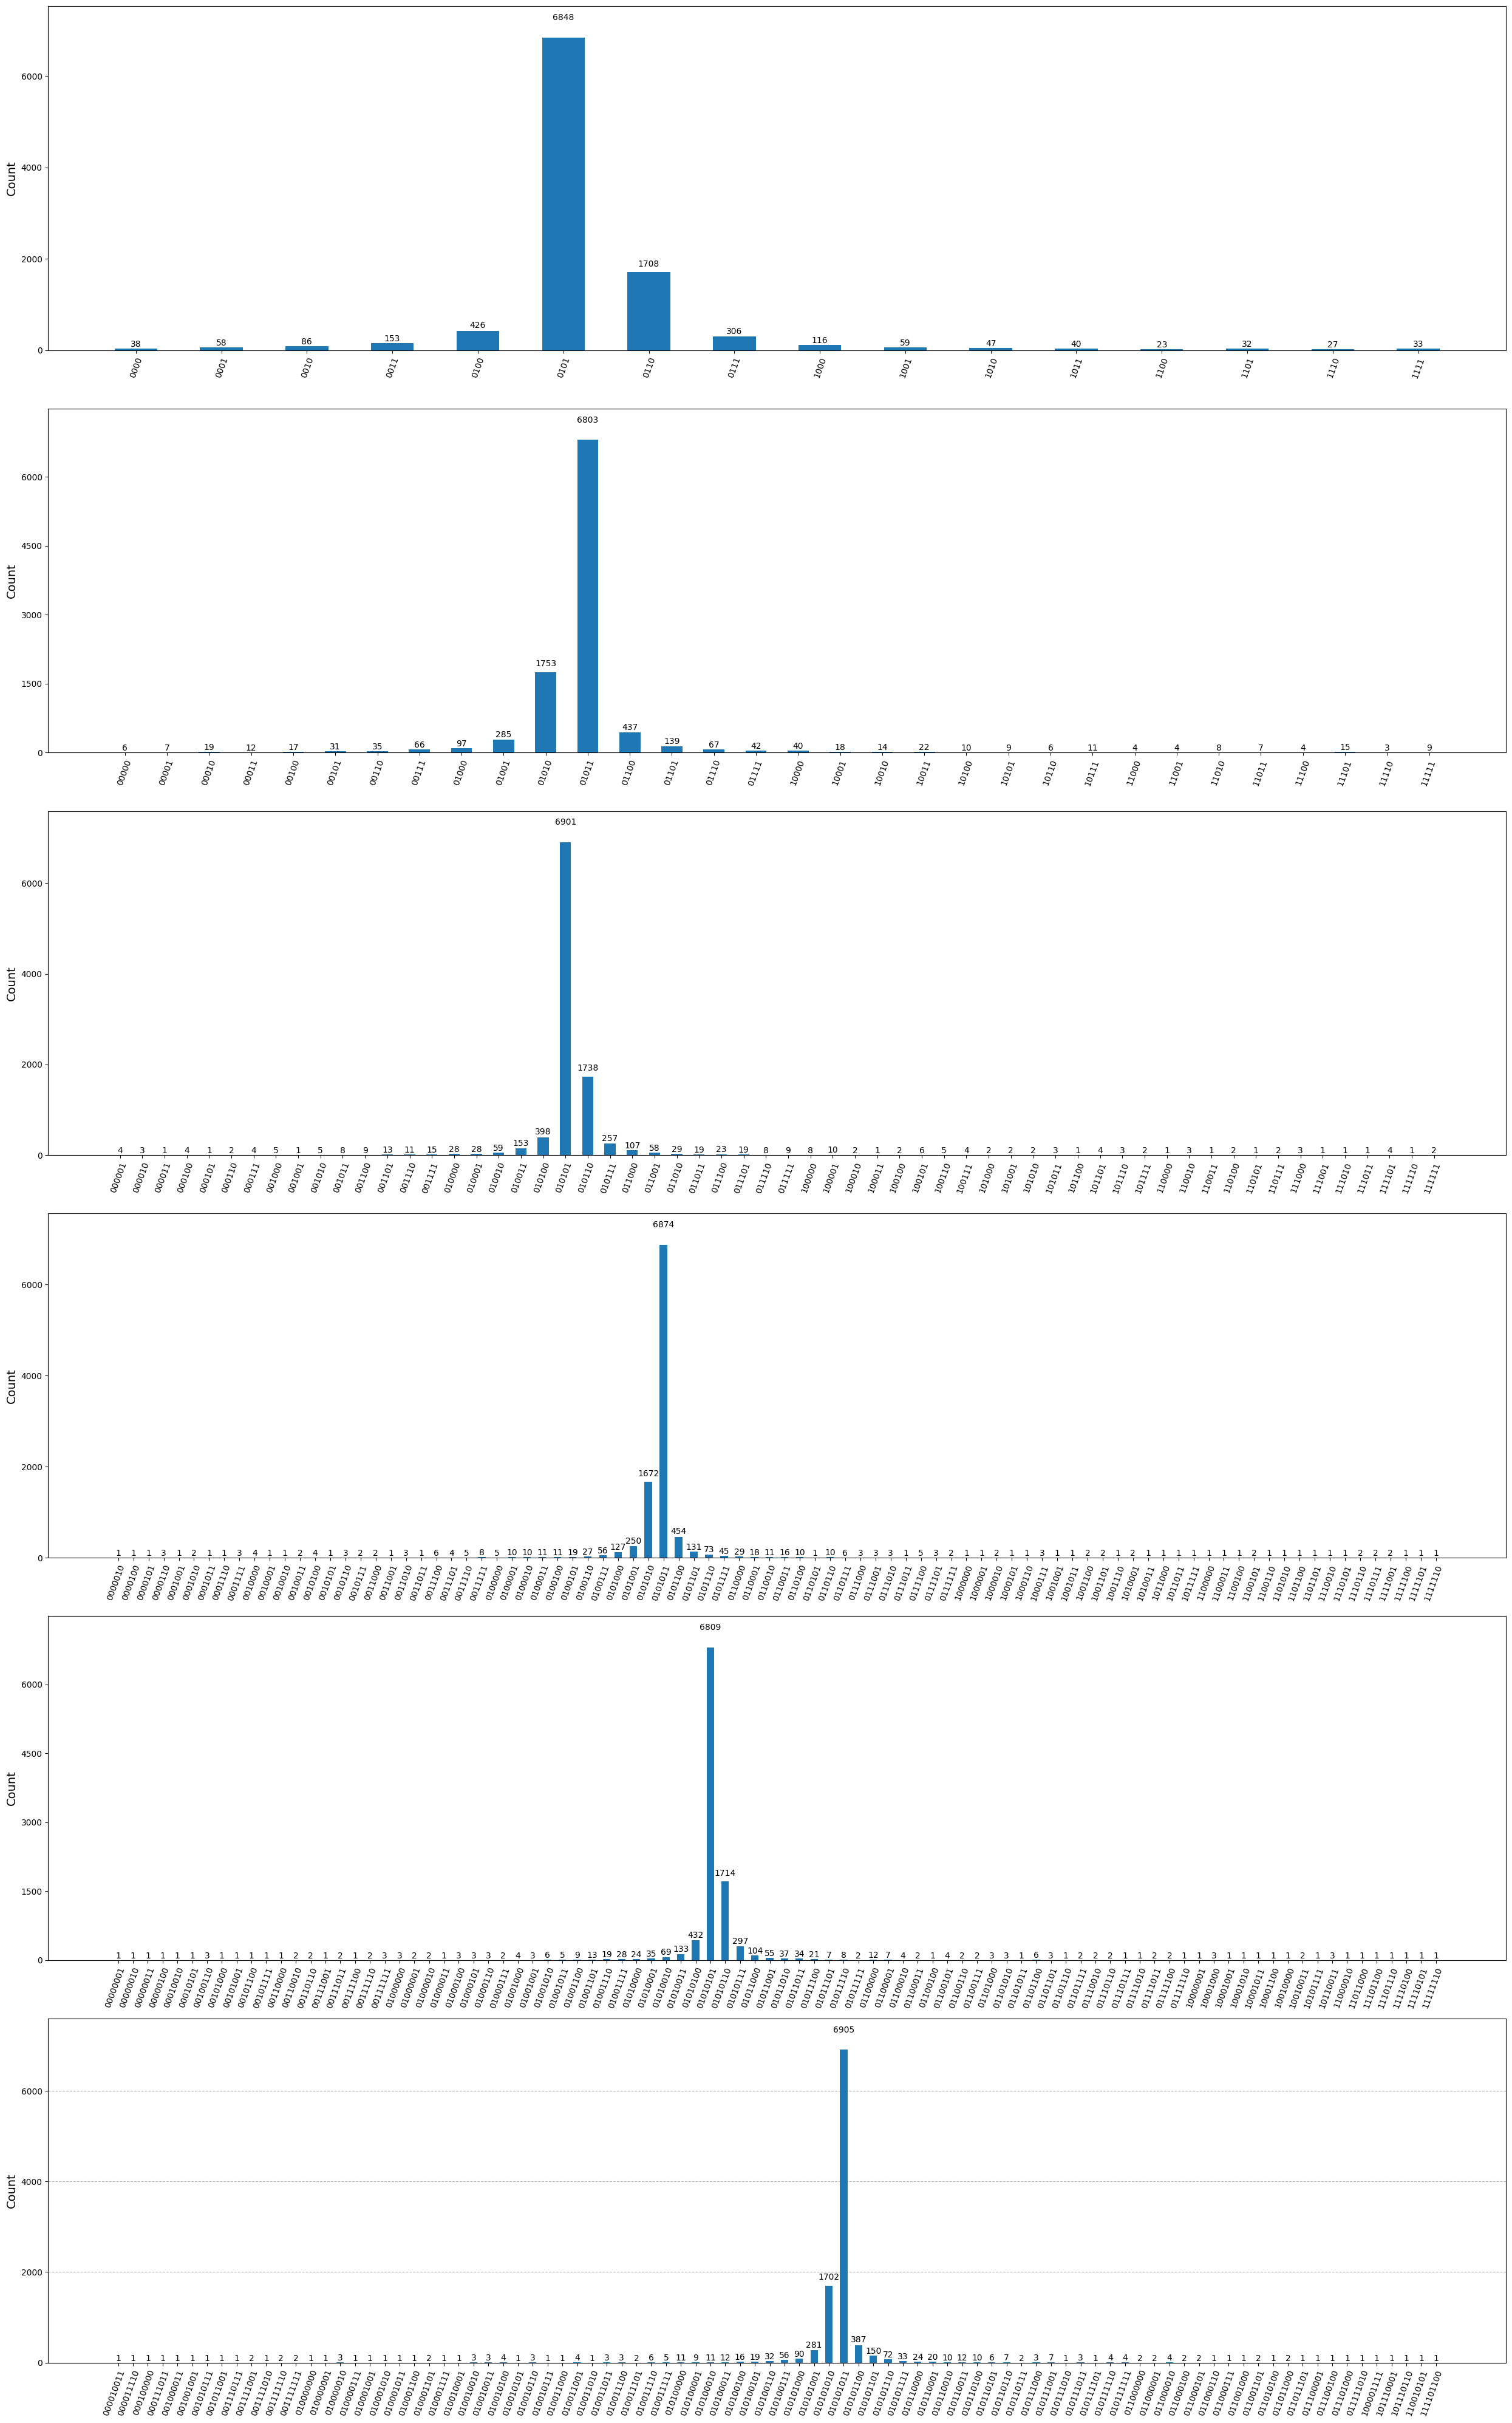

In [157]:
# Run this cell to simulate `circ` and plot the histograms of the results


backend = AerSimulator()
shots=1000
# Transpile the ideal circuit to a circuit that can be directly executed by the backend
transpiled_circuit = transpile(circ, backend)

n_circ = len(circ)


# Since the output will be deterministic, we can use just a single shot to get it
job = backend.run(transpiled_circuit, shots=10000, memory=True) #I needed to modify the shots to get the expected noise results
results = job.result()


counts = [results.get_counts(idx) for idx in range(n_circ)]

fig, ax = plt.subplots(n_circ,1,figsize=(25,40))
for idx in range(n_circ):
    plot_histogram(counts[idx], ax=ax[idx])
plt.tight_layout()

#### Step B. Determine $e$, the maximum difference in integer from the best estimation for the different numer of counting qubits, $t=[4,5,6,7,8,9]$. Verify the relationship $e=2^{t-n}-1$ where $n=2$ since the desired accuracy is $2^{-2}$ in this case.

In [39]:
## Your Code goes here
b = .3125
range_acc = .25
elist = []
counter = 0
for ct in range(4,10): #loop over each circuit
    phi_est_2 = sorted(np.array([round(int(k, 2)/2**ct,3) for k in list(counts[counter].keys())]))
    #print(phi_est_2)
    updated = []
    for m in phi_est_2: #loop over phi_est, if the term is > .25 off from b then we don't want it
        if np.abs(m-b) <= range_acc:
            updated.append(np.abs(m-b))
    #e = int(((len(updated) - 1)/2)) #this will result in the minimal e such that all m's approximate phi =1/3 to an accuracy 
    max_val = np.max(updated)
    e = int(max_val*(2**ct))
    elist.append(e)
    print("For t =", ct, "--> e =", e)
    counter = counter+1
    

For t = 4 --> e = 3
For t = 5 --> e = 7
For t = 6 --> e = 15
For t = 7 --> e = 31
For t = 8 --> e = 63
For t = 9 --> e = 123


If you successfully calculated $e$ values for all the counting qubits $t=[4,5,6,7,8,9]$, you will be able to generate the following graph that verifies the relationship $e=2^{t-2}-1$ with the values that you computed.

![title](L5_e_max.png)

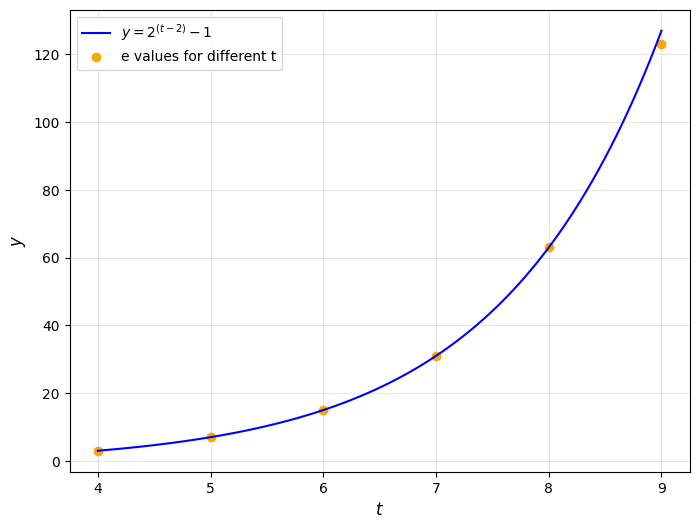

In [40]:
## Your Code goes here
def func_t(t):
    return 2**(t-2) - 1
t_values = np.linspace(4,9,100)
y_values = func_t(t_values)

t_vals_disc = [4,5,6,7,8,9]

plt.figure(figsize=(8, 6))
plt.plot(t_values, y_values, label=r"$y = 2^{(t-2)} - 1$", color="blue")
plt.scatter(t_vals_disc, elist, color = "orange", label = "e values for different t")
plt.legend()
plt.xlabel("$t$", fontsize=12)
plt.ylabel("$y$", fontsize=12)
plt.grid(alpha=0.3)

#### Step C. Evaluate the probability of success estimating $\phi$ to an accuracy $2^{-2}$ for all the values of $t$, the number of counting qubits. Save the probabilities to the list variable, 'prob_success'.

In [ ]:
## Your Code goes here
prob_success = []
counter = 0
for ct in range(4,10): #loop over each circuit
    #print(counter)
    phi_est_2 = sorted(np.array([round(int(k, 2)/2**ct,3) for k in list(counts[counter].keys())]))
    key_new = list(map(str, phi_est_2))
    temp_count = dict(sorted(counts[counter].items()))
    count_new = dict(zip(key_new, list(temp_count.values())))
    #print(count_new)
    max_key = max(count_new, key=count_new.get)
    temp_ind = phi_est_2.index(float(max_key))
    total_count = 0
    corr_count = 0
    for i in range(len(phi_est_2)):
        if np.abs(i-temp_ind) <=elist[counter]:
            corr_count = corr_count + list(count_new.values())[i]
        total_count = total_count + list(count_new.values())[i]
    prob_success.append(corr_count/total_count)
    counter = counter + 1
print(prob_success)


[0.9668, 0.983, 0.9919, 0.9976, 1.0, 1.0]


#### Step D. Overlay the results of Step C on the graph that shows the relationship between the number of counting qubits $t$, and the minimum probability of success to approximate the phase to an accuracy $2^{-2}$. Understand the result.

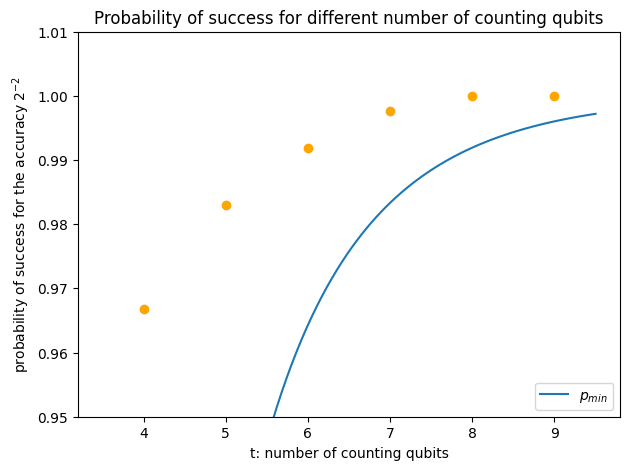

In [51]:
## Your code goes here
y = lambda t, n: 1-1/(2*(2**(t-n)-2))
t_q = np.linspace(3.5, 9.5, 100 )
p_min = y(t_q, 2)

plt.figure(figsize=(7, 5))
plt.plot(t_q, p_min, label='$p_{min}$')
plt.scatter(t_vals_disc, prob_success, color = "orange")
plt.xlabel('t: number of counting qubits')
plt.ylabel('probability of success for the accuracy $2^{-2}$')
plt.ylim(.95,1.01)
plt.legend(loc='lower right')
plt.title('Probability of success for different number of counting qubits')
plt.show()

Here, the reason the 8 and 9 qubit results approach 1 is because the noise is concentrated pretty close to the b value. 

![title](L5_prob_t.png)

Your plot should be similar to the above one. The line plot in the left pannel shows the minimum success probability to estimate $\phi$ within the accuracy $2^{-2}$ as the number of counting qubits varies. The overlayed orange dots are the same values, but from the simulation, which confirms the relationship the line plot represents as the lower bound. The right pannel displays the same result but zoomed by adjusting the y-axis range.

The following graph exhibits the relationships with different accuracy levels. The relationship, $t=n+\log(2+\frac{1}{2\epsilon})$, indicates the number of counting qubits $t$ to estimate $\phi$ to an accuracy $2^{-2}$ with probability of success at least $1-\epsilon$, as we validated above.

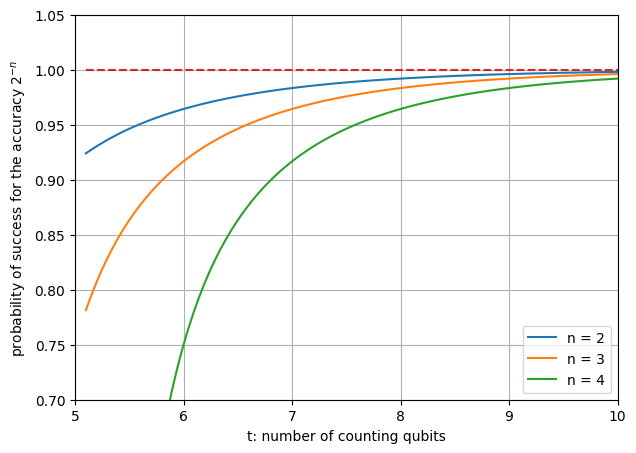

In [26]:
t = np.linspace(5.1, 10, 100)
prob_success_n = [y(t, n) for n in [2, 3, 4]]
prob_n2, prob_n3, prob_n4  = prob_success_n[0], prob_success_n[1], prob_success_n[2]

plt.figure(figsize=(7, 5))
plt.plot(t, prob_n2, t, prob_n3, t, prob_n4, t, [1]*len(t),'--' )
plt.axis([5, 10, 0.7, 1.05])
plt.xlabel('t: number of counting qubits')
plt.ylabel('probability of success for the accuracy $2^{-n}$')
plt.legend(['n = 2', 'n = 3', 'n = 4'], loc='lower right')
plt.grid(True)

# Part2. Use noisy fake quantum computer and redo the above experiment

Goal

Run the QPE circuit on a real quantum system to understand the result and limitations when using noisy quantum systems

The accuracy anaylsis that we performed in Part 1 would not be correct when the QPE circuit is executed on present day noisy quantum systems. In part 2, we will obtain QPE results by running the circuit on a fake backend to examine how noise affects the outcome and learn techniques to reduce its impact.

#### Step A: Import the fackbackend

In [181]:
from qiskit.providers.fake_provider import GenericBackendV2


coupling_map=[[0, 4], [0, 2], [4, 2], [2, 3], [4, 1], [0, 5]]

# Generate a 6-qubit simulated backend
backend = GenericBackendV2(num_qubits=6,coupling_map=coupling_map)


# Customize the noise level on each fake qubit.
# Please don't modify it during your experiment
backend.target['measure'][(0,)].error = 0.05
backend.target['measure'][(4,)].error = 0.05
backend.target['measure'][(2,)].error = 0.05

for (i,j) in coupling_map:
        backend.target['cx'][(i,j)].error = 0.08        
  
backend.target['measure'][(3,)].error = 0.05
backend.target['measure'][(1,)].error = 0.05
backend.target['measure'][(5,)].error = 0.05

#### Step B. Generate multiple ( as many as you want ) transpiled circuits of qc4 that you set up in Part 1 at the beginning. Choose one with the minimum circuit depth, and the other with the maximum circuit depth.

Transpile the circuit with the parameter optimization_level = 3 to reduce the error in the result. As we learned in Lab 1, Qiskit by default uses a stochastic swap mapper to place the needed SWAP gates, which varies the tranpiled circuit results even under the same runtime settings. Therefore, to achieve shorter depth transpiled circuit for smaller error in the outcome, transpile qc4 multiple times and choose one with the minimum circuit depth. Select the maximum circuit depth one as well for comparison purposes.

In [102]:
## Your code goes here
qc1, counts1 = qc4()
trans1_qc1 = transpile(qc1, backend=backend, optimization_level=3)
print("Transpiled circuit 1 depth:", trans1_qc1.depth())
trans2_qc1 = transpile(qc1, backend=backend, optimization_level=3)
print("Transpiled circuit 2 depth:", trans2_qc1.depth())
trans3_qc1 = transpile(qc1, backend=backend, optimization_level=3)
print("Transpiled circuit 3 depth:", trans3_qc1.depth())



Transpiled circuit 1 depth: 73
Transpiled circuit 2 depth: 65
Transpiled circuit 3 depth: 79


Here, we will choose circuit 2 as our min and circuit 3 as our max

#### Step C. Execute both circuits on the fake backend. Plot the histogram for the results and compare them with the simulation result in Part 1. Discuss the difference between ideal simulation and noisy simualtion with minimum and maxmimum depth.

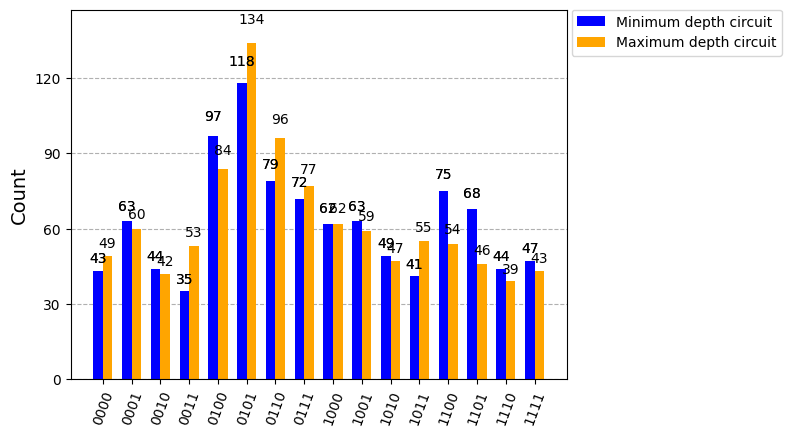

In [111]:
## Your code goes here
job1 = backend.run(trans2_qc1, shots=1000, memory=True)
output1 = job1.result().get_counts()

job2 = backend.run(trans3_qc1, shots=1000, memory=True)
output2 = job2.result().get_counts()

plot_histogram([output1, output2], legend=["Minimum depth circuit", "Maximum depth circuit"], color =["blue","orange"])


Clearly, these results are significantly noisier and worse than the results we got in Part 1 with only between 11.8-13.4% of the executions giving us the best estimation. There is also not a particularly large drop off (although there definitley seems to be one present) from the answers closest to the best estimation as opposed to the ones all the way on the poles (i.e. 0000 and 1111). It appears that the maximum depth circuit is slightly more accurate as opposed to the minimum depth circuit when executed on the noisy simulator. The max depth circuit has a higher % of results within 2^-2 of the target as well (54.8% vs. 50.7%).

# Additional task

Do the lab again, but this time going for a phase value accurate to $2^{-3}$. Call the function qc4improved. 
In Part 2, Step B, show your code with minimum circuit depth. 
In Part 2, step C, show your code and show your three histograms. 
Discuss whether going for a phase value accurate to $2^{-3}$ gave an improvement compared to going for $2^{-2}$.

You can copy the following implemenetation to the test script and run the test by yourselves!
https://github.com/yezhuoyang/QuantumLab/blob/main/test/testPhaseEstimation.py

In [178]:
def qc4improved(): #the noisy backend only allows us to go up to 6 counting qubits so that is what we will define this with!
    ## Start your code to create the circuit
    n=6 #How man qubit you want to use?
    m=5 #How many classical bit your want to use?
    circuit=QuantumCircuit(n, m)


    ##Your circuit construction goes here:

    #initializing bits
    #circuit.reset(range(n))
    for qubit in range(n-1):
        circuit.h(qubit)
    circuit.x(n-1) #initialize to eigenstate |1>
    circuit.barrier()
    #U gate applications
    reps = 1
    for qb in range(n-1):
        for i in range(reps):
            circuit.cp((2*np.pi)/3, qb, n-1)
        reps = reps*2
    circuit.barrier()
    #Inverse QFT
    circuit = inverse_qft(circuit, n-1)
    #measurement
    for qubit2 in range(n-1):
        circuit.measure(qubit2,qubit2)


    ##Your circuit construction ends here


    # We'll run the program on a simulator
    backend = AerSimulator()

    # Transpile the ideal circuit to a circuit that can be directly executed by the backend
    transpiled_circuit = transpile(circuit, backend)

    # Since the output will be deterministic, we can use just a single shot to get it
    job = backend.run(transpiled_circuit, shots=1000, memory=True)
    output = job.result().get_counts()

    return circuit, output

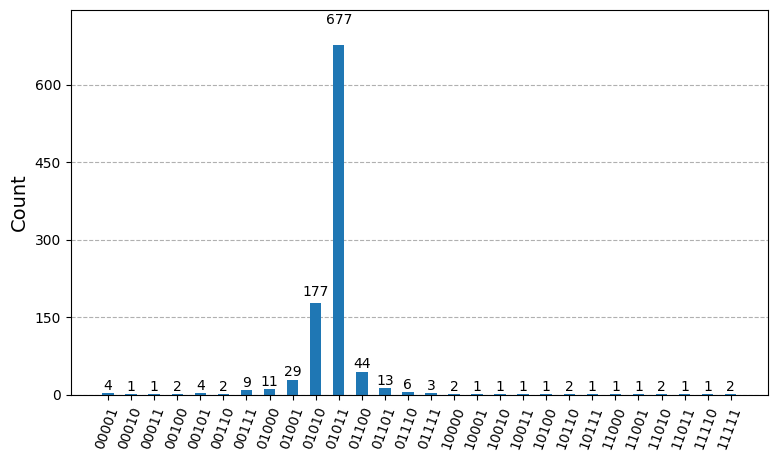

In [165]:
qc4_circuit,count_qc4=qc4improved()
plot_histogram(count_qc4, figsize=(9,5))

# Calculating e again

In [166]:
t=5
b = .3125
phi_est = sorted(np.array([round(int(k, 2)/2**t,3) for k in list(count_qc4.keys())]))
range_acc = .125
updated = []
for m in phi_est: #loop over phi_est, if the term is > .25 off from b then we don't want it
    if np.abs(m-b) <= range_acc:
        updated.append(np.abs(m-b))
print(updated)
max_val = np.max(updated) #take the maximum difference in |m-b|, we find e from solving max<= e/2^t
e = int(max_val*(2**t)) #this will result in the minimal e such that all m's approximate phi =1/3 to an accuracy 
print("Here, e =", e)


[np.float64(0.1245), np.float64(0.0935), np.float64(0.0625), np.float64(0.03149999999999997), np.float64(0.0005000000000000004), np.float64(0.03149999999999997), np.float64(0.0625), np.float64(0.09350000000000003)]
Here, e = 3


# calculating probabilities again

In [185]:
#we know e = 3 from my code above
e = 3
t = 5
b = .3125


key_new = list(map(str, phi_est))
temp_count = dict(sorted(count_qc4.items()))
count_new = dict(zip(key_new, list(temp_count.values())))
#print(count_new)
max_key = max(count_new, key=count_new.get)
temp_ind = phi_est.index(float(max_key))
#print(temp_ind)


corr_count = 0
total_count = 0
for i in range(len(phi_est)):
    if np.abs(i-temp_ind) <=e:
            corr_count = corr_count + list(count_new.values())[i]
    total_count = total_count + list(count_new.values())[i]
print("The probability of a successful approximation is:", corr_count/total_count)
val_thresh = 1-(1/(2*(2**(t-2) - 2)))
print("The value it must be larger than is:", val_thresh)

The probability of a successful approximation is: 0.957
The value it must be larger than is: 0.9166666666666666


# Part 2B Additional Task

In [183]:
## Your code goes here
qc1, counts1 = qc4improved()

trans1_qc1 = transpile(qc1, backend=backend, optimization_level=3)
print("Transpiled circuit 1 depth:", trans1_qc1.depth())
trans2_qc1 = transpile(qc1, backend=backend, optimization_level=3)
print("Transpiled circuit 2 depth:", trans2_qc1.depth())
trans3_qc1 = transpile(qc1, backend=backend, optimization_level=3)
print("Transpiled circuit 3 depth:", trans3_qc1.depth())
trans4_qc1 = transpile(qc1, backend=backend, optimization_level=3)
print("Transpiled circuit 4 depth:", trans4_qc1.depth())
trans5_qc1 = transpile(qc1, backend=backend, optimization_level=3)
print("Transpiled circuit 5 depth:", trans5_qc1.depth())


Transpiled circuit 1 depth: 114
Transpiled circuit 2 depth: 123
Transpiled circuit 3 depth: 123
Transpiled circuit 4 depth: 118
Transpiled circuit 5 depth: 106


Here, we will choose circuit 5 as our min and circuit 2 as our max

# Part 2C Additional Task

In [159]:
phi_est_2 = sorted(np.array([round(int(k, 2)/2**5,3) for k in list(counts[1].keys())]))
print(phi_est_2)

[np.float64(0.0), np.float64(0.031), np.float64(0.062), np.float64(0.094), np.float64(0.125), np.float64(0.156), np.float64(0.188), np.float64(0.219), np.float64(0.25), np.float64(0.281), np.float64(0.312), np.float64(0.344), np.float64(0.375), np.float64(0.406), np.float64(0.438), np.float64(0.469), np.float64(0.5), np.float64(0.531), np.float64(0.562), np.float64(0.594), np.float64(0.625), np.float64(0.656), np.float64(0.688), np.float64(0.719), np.float64(0.75), np.float64(0.781), np.float64(0.812), np.float64(0.844), np.float64(0.875), np.float64(0.906), np.float64(0.938), np.float64(0.969)]


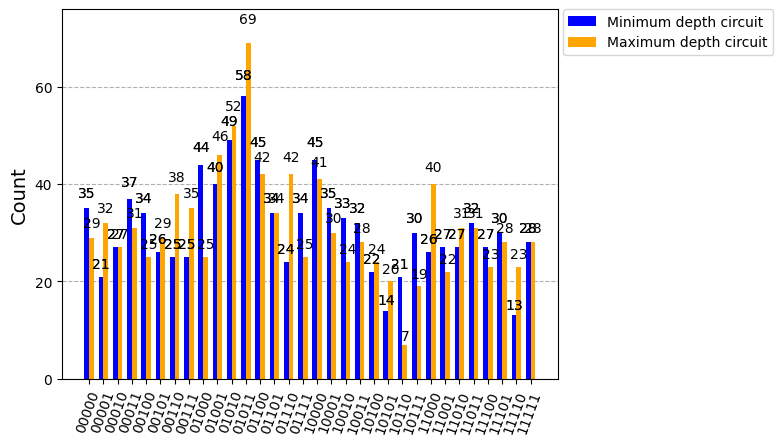

In [187]:
job1 = backend.run(trans5_qc1, shots=1000, memory=True)
output1 = job1.result().get_counts()

job2 = backend.run(trans2_qc1, shots=1000, memory=True)
output2 = job2.result().get_counts()

plot_histogram([output1, output2], legend=["Minimum depth circuit", "Maximum depth circuit"], color =["blue","orange"])

Going for a phase of 2^-3 significantly lowers the amount of counts on the target (01011) (5.8% for min depth, 6.9% for max depth). The amount of results within 2^-3 for min depth is also significantly lower since our e is only 3 for a minimum depth of 2^-3. While the accuracy is a bit better for the non-noisy simulator, it is significantly worse on the noisy simulator since the circuits are larger (causing more measurment error) and there is a smaller e value.

# Testing

In [125]:
def testqc4():
    circuit,output=qc4()
    result=max(output, key=output.get)
    phase=int(result, base=2)/(2**(len(result)))
    answer=1/3
    diff=abs(phase-answer)
    if(diff/(answer))<(2**(-2)):
        print(colored('Congrats, qc4 Test passed ','green')+"\U0001f600")
    else:
        print(colored('OOPS, qc Test failed! Your estimated phase is '+str(phase)+" is not accurate enough!",'red')+"\U0001F923")      



def testqc4improved():
    circuit,output=qc4improved()
    result=max(output, key=output.get)
    phase=int(result, base=2)/(2**(len(result)))
    answer=1/3
    diff=abs(phase-answer)
    if (diff/(answer))<(2**(-3)):
        print(colored('Congrats, qc4improved Test passed ','green')+"\U0001f600")
    else:
        print(colored('OOPS, qcimproved Test failed! Your estimated phase is '+str(phase)+" is not accurate enough!",'red')+"\U0001F923")    






if __name__ == '__main__':
    print("-----------Strating the tests of IBM Lab2: Quantum phase estimation-----------")
    testqc4()
    testqc4improved()
    #print("--------------------------Your score is:--------------------------")   

-----------Strating the tests of IBM Lab2: Quantum phase estimation-----------
Congrats, qc4 Test passed 😀
Congrats, qc4improved Test passed 😀
